# Some testing

In [1]:
import pandas as pd
import numpy as np
from preprocessing import clean_data, remove_missing, simple_clean
from sklearn.model_selection import train_test_split

# Load df from csv
raw_data = pd.read_csv("data/train.csv", index_col=0)

# Clean data using function
df = remove_missing(clean_data(raw_data))


# Split data into X and y
X, y = df.drop(columns=['target'], axis=1), df['target']

# Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

### LightGBM

In [2]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Create a LightGBM dataset from the train and test sets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Define hyperparameters
params = {'objective': 'regression', 
          'metric': 'rmse', 
          'num_leaves': 31, 
          'learning_rate': 0.05, 
          'verbose': -1}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[test_data])

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test)
preds_mean = np.array([y_train.mean()] * len(y_test))

# RMSE evaluation, compare real to baseline (mean)
lgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
rmse_mean = np.sqrt(mean_squared_error(y_test, preds_mean))

print("RMSE:", lgb_rmse)
print("Mean pred RMSE:", rmse_mean)

[1]	valid_0's rmse: 51.8237
[2]	valid_0's rmse: 51.8105
[3]	valid_0's rmse: 51.8086
[4]	valid_0's rmse: 51.8326
[5]	valid_0's rmse: 51.8364
[6]	valid_0's rmse: 51.8325
[7]	valid_0's rmse: 51.8347
[8]	valid_0's rmse: 51.7852
[9]	valid_0's rmse: 51.7961
[10]	valid_0's rmse: 51.818
[11]	valid_0's rmse: 51.8331
[12]	valid_0's rmse: 51.8158
[13]	valid_0's rmse: 51.7782
[14]	valid_0's rmse: 51.7467
[15]	valid_0's rmse: 51.7321
[16]	valid_0's rmse: 51.7374
[17]	valid_0's rmse: 51.7644
[18]	valid_0's rmse: 51.7503
[19]	valid_0's rmse: 51.766
[20]	valid_0's rmse: 51.7571
[21]	valid_0's rmse: 51.7586
[22]	valid_0's rmse: 51.7965
[23]	valid_0's rmse: 51.8142
[24]	valid_0's rmse: 51.8084
[25]	valid_0's rmse: 51.7905
[26]	valid_0's rmse: 51.7874
[27]	valid_0's rmse: 51.8108
[28]	valid_0's rmse: 51.7669
[29]	valid_0's rmse: 51.8069
[30]	valid_0's rmse: 51.809
[31]	valid_0's rmse: 51.7891
[32]	valid_0's rmse: 51.773
[33]	valid_0's rmse: 51.7797
[34]	valid_0's rmse: 51.763
[35]	valid_0's rmse: 51.7699

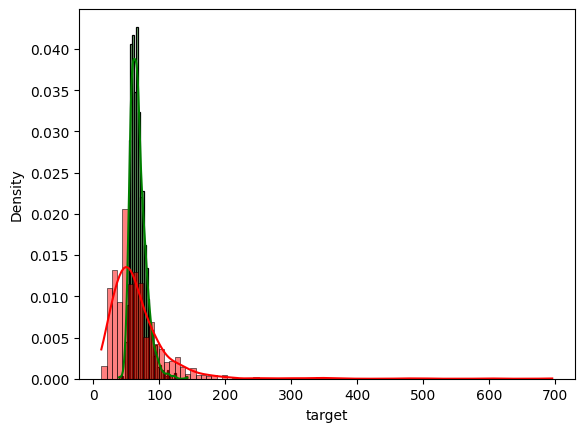

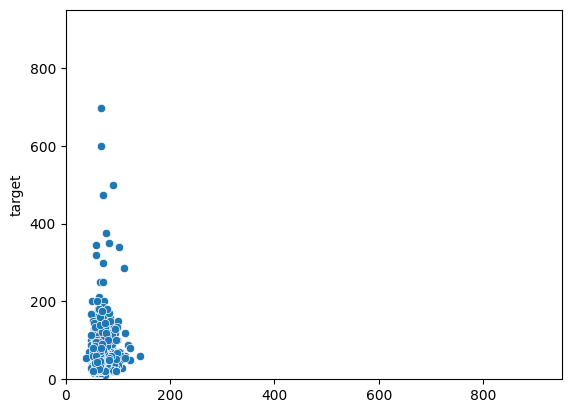

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

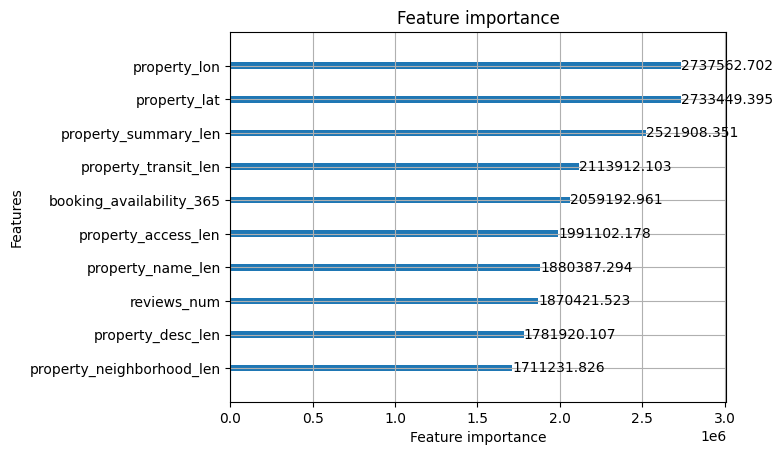

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Histogram of predictions and real values
sns.histplot(y_pred_lgb, kde=True, stat="density", color="green")
sns.histplot(y_test, kde=True, stat="density", color="red")

# Scatterplot of predictions and real values
fig, ax = plt.subplots()
sns.scatterplot(x=y_pred_lgb, y=y_test, ax=ax)
ax.set_xlim(0, 950)
ax.set_ylim(0, 950)
plt.show()

# Feature importance
lgb.plot_importance(lgb_model, max_num_features=10, importance_type='gain')

### XGBoost

In [4]:
import xgboost as xgb

# Create model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
preds_mean = np.array([y_train.mean()] * len(y_test))

# Calculate rmse
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
rmse_mean = np.sqrt(mean_squared_error(y_test, preds_mean))

print("RMSE:", xgb_rmse)
print("Mean pred RMSE:", rmse_mean)


RMSE: 55.448818282858234
Mean pred RMSE: 51.85477626656312


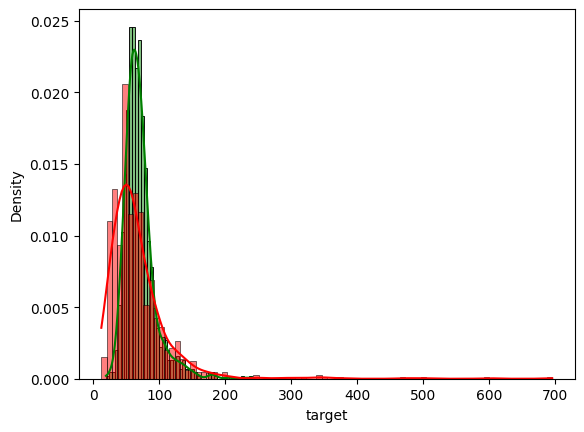

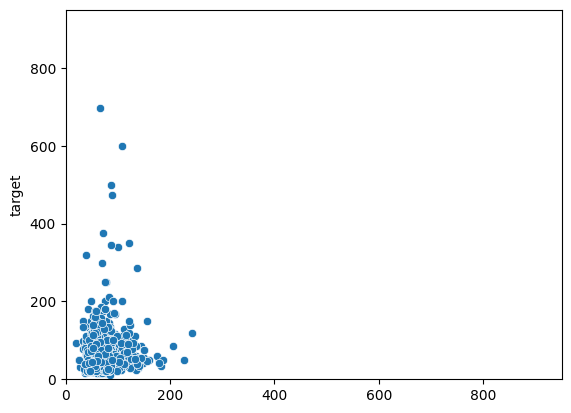

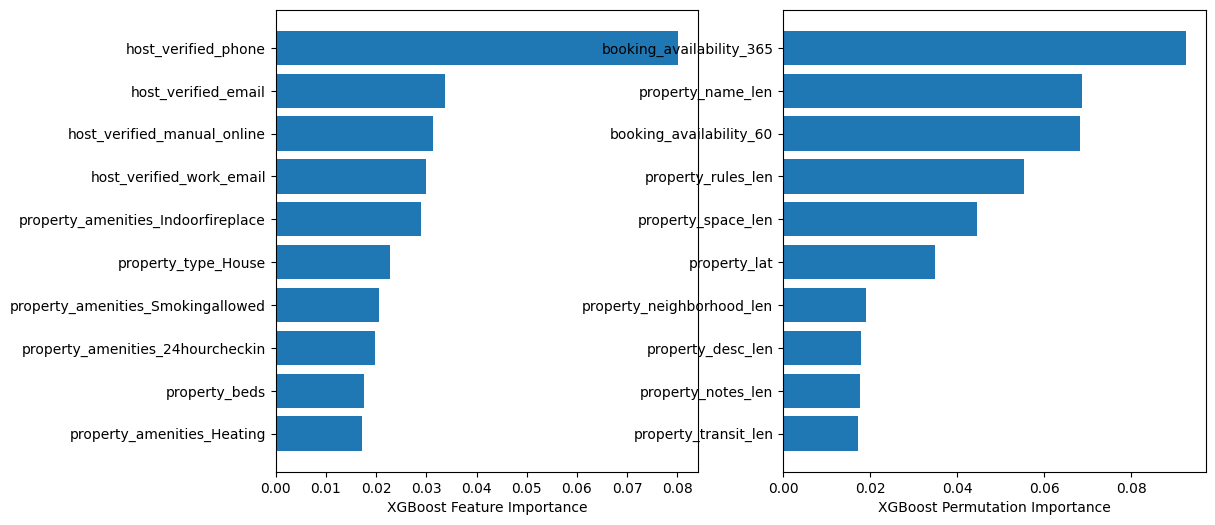

In [5]:
# Histogram of predictions and real values
sns.histplot(y_pred_xgb, kde=True, stat="density", color="green")
sns.histplot(y_test, kde=True, stat="density", color="red")

# Scatterplot of predictions and real values
fig, ax = plt.subplots()
sns.scatterplot(x=y_pred_xgb, y=y_test, ax=ax)
ax.set_xlim(0, 950)
ax.set_ylim(0, 950)
plt.show()


# Feature importance
fi_sorted_xgb = xgb_model.feature_importances_.argsort()

# Permutation importance
xgb_perm_importance = permutation_importance(xgb_model, X_test, y_test)
pi_sorted_xgb = xgb_perm_importance.importances_mean.argsort()

# Print feature importance and permutation importance side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.barh(df.columns[fi_sorted_xgb][-10:], xgb_model.feature_importances_[fi_sorted_xgb][-10:])
ax1.set_xlabel("XGBoost Feature Importance")
ax2.barh(df.columns[pi_sorted_xgb][-10:], xgb_perm_importance.importances_mean[pi_sorted_xgb][-10:])
ax2.set_xlabel("XGBoost Permutation Importance")
plt.show()


### Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

# Create model
rf_model = RandomForestRegressor(n_estimators=50)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)
preds_mean = np.array([y_test.mean()] * len(y_test))

# Calculate rmse
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_mean = np.sqrt(mean_squared_error(y_test, preds_mean))

print(rf_rmse)
print(rmse_mean)


53.76195621485203
51.854502546423106


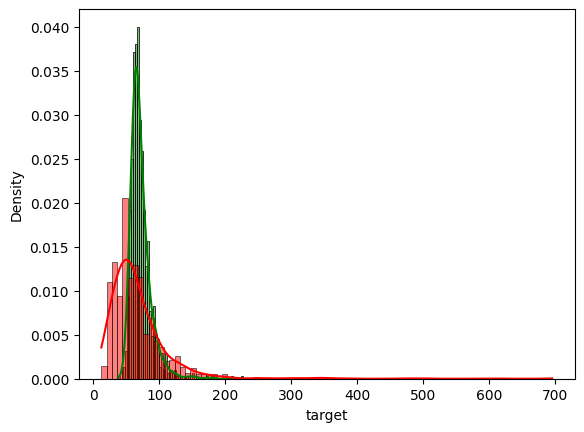

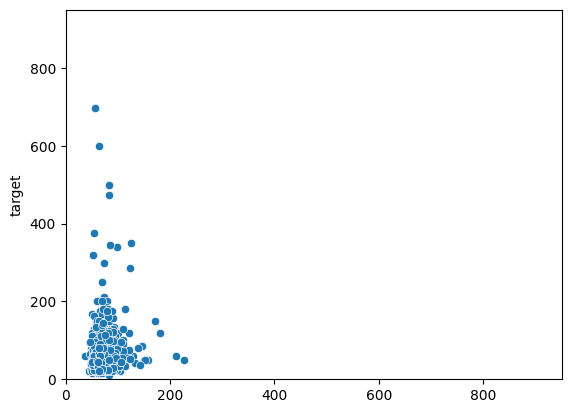

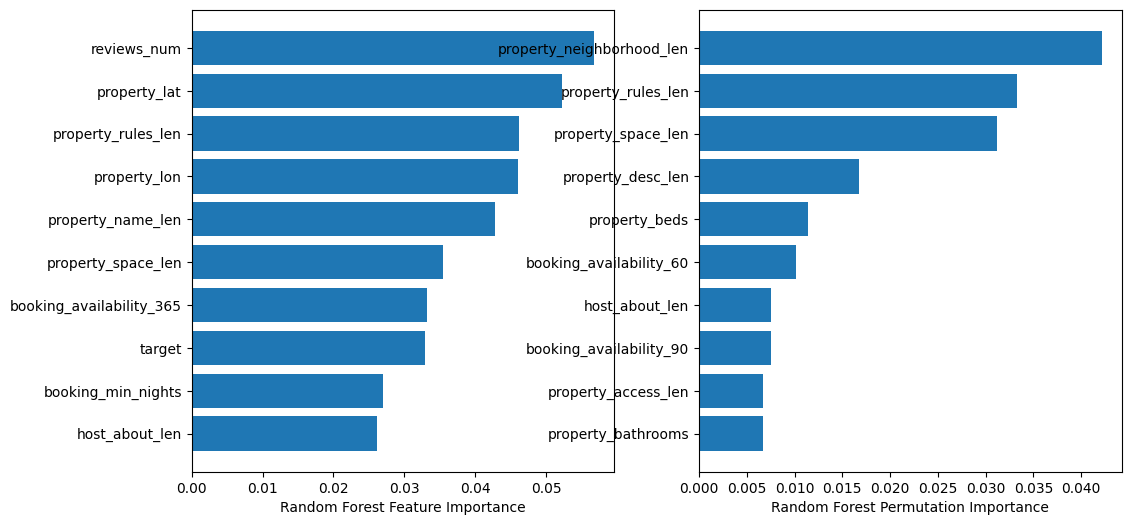

In [7]:
# Histogram of predictions and real values
sns.histplot(y_pred_rf, kde=True, stat="density", color="green")
sns.histplot(y_test, kde=True, stat="density", color="red")

# Scatterplot of predictions and real values
fig, ax = plt.subplots()
sns.scatterplot(x=y_pred_rf, y=y_test, ax=ax)
ax.set_xlim(0, 950)
ax.set_ylim(0, 950)
plt.show()

# Feature importance
fi_sorted_rf = rf_model.feature_importances_.argsort()

# Permutation importance
rf_perm_importance = permutation_importance(rf_model, X_test, y_test)
pi_sorted_rf = rf_perm_importance.importances_mean.argsort()

# Print feature importance and permutation importance side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.barh(df.columns[fi_sorted_rf][-10:], rf_model.feature_importances_[fi_sorted_rf][-10:])
ax1.set_xlabel("Random Forest Feature Importance")
ax2.barh(df.columns[pi_sorted_rf][-10:], rf_perm_importance.importances_mean[pi_sorted_rf][-10:])
ax2.set_xlabel("Random Forest Permutation Importance")
plt.show()